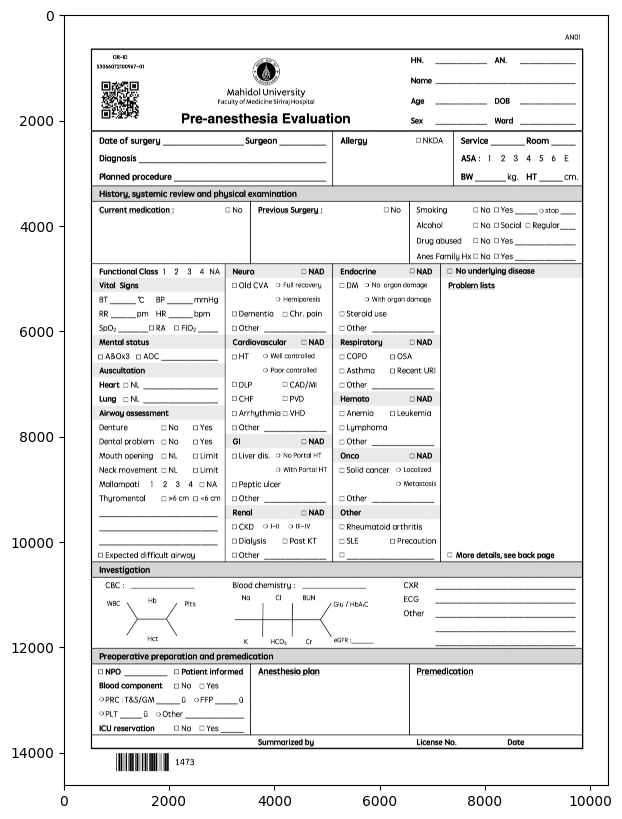

In [39]:
import fitz  # PyMuPDF
import numpy as np
import cv2
import matplotlib.pyplot as plt

def pdf_to_image(pdf_path, dpi=300):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(matrix=fitz.Matrix(dpi/72, dpi/72))
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, 3)
        images.append(img)
    return images

# โหลด PDF
pdf_path = "data/Revised Anes Record Form.pdf"
images = pdf_to_image(pdf_path)

# แสดงภาพหน้าแรก
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()


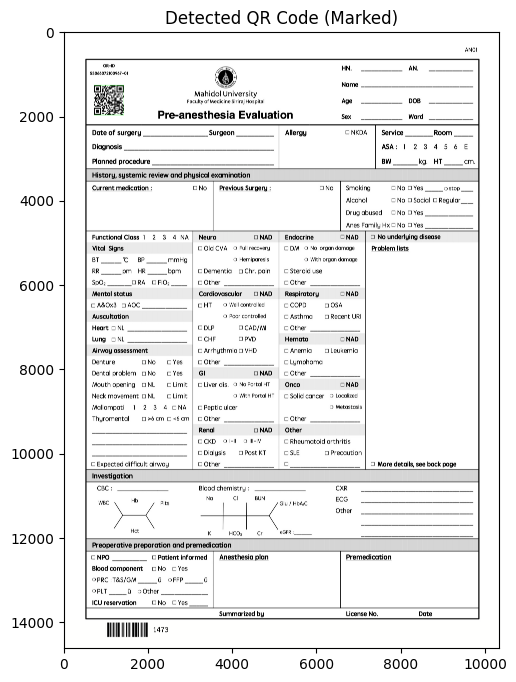

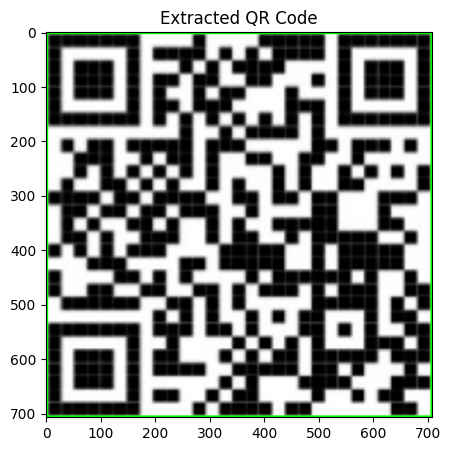

'https://me-qr.com/voHoMww2'

In [40]:
import cv2
import matplotlib.pyplot as plt
import json
from pyzbar.pyzbar import decode
import numpy as np

def read_qr_code(image):
    image_copy = image.copy()  # Make a writable copy of the image
    decoded_objects = decode(image_copy)
    
    if decoded_objects:
        for obj in decoded_objects:
            points = obj.polygon
            if len(points) > 4:  # If the points form a polygon
                hull = cv2.convexHull(np.array([point for point in points], dtype=np.float32))
                points = hull.reshape(-1, 2)
            points = np.array(points, dtype=np.int32)
            x_min, y_min = points.min(axis=0)
            x_max, y_max = points.max(axis=0)
            w, h = x_max - x_min, y_max - y_min

            # วาดกรอบรอบ QR Code
            cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)

            # แสดงภาพที่มี QR Code ถูกมาร์ค
            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
            plt.title("Detected QR Code (Marked)")
            plt.show()

            # ตัดภาพเฉพาะ QR Code
            qr_crop = image_copy[y_min:y_min + h, x_min:x_min + w]

            # แสดง QR Code แยกต่างหาก
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(qr_crop, cv2.COLOR_BGR2RGB))
            plt.title("Extracted QR Code")
            plt.show()

            return obj.data.decode('utf-8'), points

    return None, None

qr_data, qr_points = read_qr_code(images[0])
qr_data

# แสดงข้อมูลจาก qrcode
if qr_data:
    try:
        data = json.loads(qr_data)
    except json.JSONDecodeError:
        data = qr_data  # If qr_data is not JSON, just return the raw data
else:
    data = "No QR code data found"
data

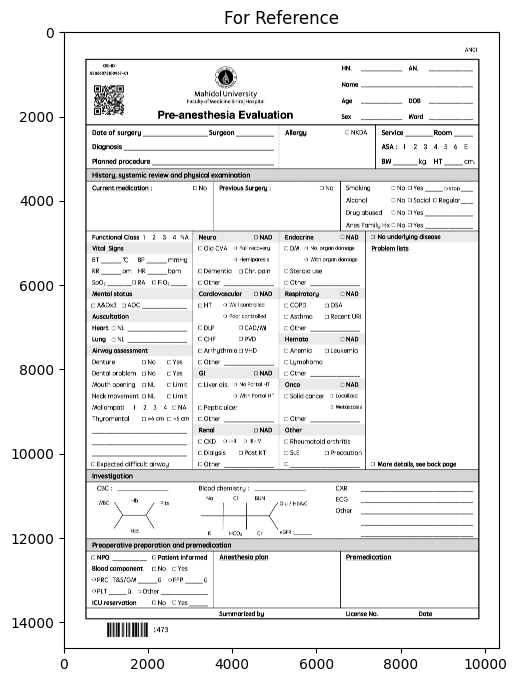

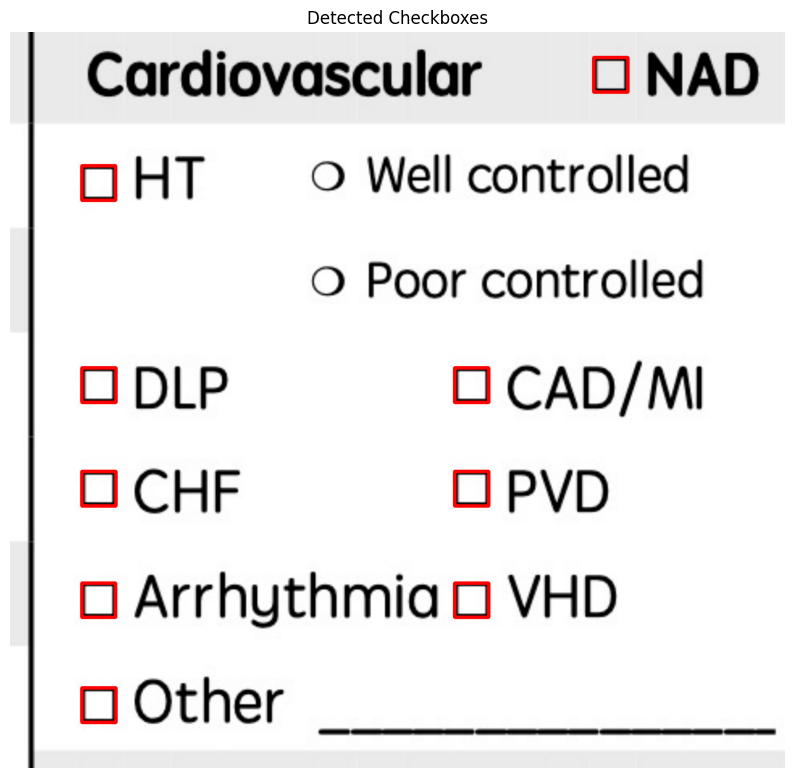

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# สร้างสำเนาของภาพจาก images[0]
image_copy = images[0].copy()

# แสดงภาพที่มี QR Code ถูกมาร์ค
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("For Reference")
plt.show()

def rectContour(contours):
    rectCon = []
    for i in contours:
        area = cv2.contourArea(i)
        if 4000 < area < 10000:  # กรองเฉพาะเส้นขอบที่มีพื้นที่มากกว่า 4000 แต่น้อยกว่า 10000
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if len(approx) == 4:  # กรองเฉพาะเส้นขอบที่มี 4 มุม
                rectCon.append(i)
    rectCon = sorted(rectCon, key=cv2.contourArea, reverse=True)
    return rectCon

def detect_checkboxes(image, category_box):
    # ตัดภาพเฉพาะพื้นที่ที่กำหนด
    x_min, y_min, x_max, y_max = category_box
    cropped_image = image[y_min:y_max, x_min:x_max].copy()  # Make a writable copy
    
    # แปลงภาพเป็นสีเทาและใช้ Threshold
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # ค้นหาเส้นขอบ
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = rectContour(contours)
    
    # วาดกรอบรอบ checkbox และตรวจสอบการติ๊กถูก
    for rect in rects:
        x, y, w, h = cv2.boundingRect(rect)
        checkbox = cropped_image[y:y+h, x:x+w]
        
        # ตรวจสอบว่ามีการติ๊กถูกหรือไม่ (ดูจากค่าพิกเซลสีดำ)
        total_pixels = w * h
        black_pixels = cv2.countNonZero(cv2.cvtColor(checkbox, cv2.COLOR_BGR2GRAY))
        filled_ratio = black_pixels / total_pixels
        
        # วาดกรอบรอบ checkbox
        color = (0, 255, 0) if filled_ratio > 1 else (0, 0, 255)  # สีเขียวถ้ามีการติ๊กถูก, สีแดงถ้าไม่มี
        cv2.rectangle(cropped_image, (x, y), (x+w, y+h), color, 8)
    
    # แสดงภาพที่มีการมาร์ค checkbox
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Checkboxes")
    plt.axis("off")
    plt.show()

# ตัวอย่างการใช้งาน
category_boxes = {
    "Neuro": [3000, 4700, 5000, 6100],
    "Cardiovascular": [3000, 6100, 5000, 8000],
}

# ใช้ภาพแรกจาก images แทน image ที่เป็น None
detect_checkboxes(images[0], category_boxes["Cardiovascular"])